# Practical Proportional (P) and Proportional-Integral (PI) Control

## Learning Goals

* Explain terms in the equations for proportional control and proportional-integral control/
* Derive velocity from form of PI control.
* Define terminology
    * negative feedback
    * bias (aka offset or null) term
    * proportional gain and integral gain
* Explain difference between setpoint tracking and disturbance rejection.
* Explain roles of the proportional and integral terms contribute.
* Explain the purpose of each of the following enhancements of 'textbook' PI control:
    * Anti-reset windup
         * Control algorithm modifications
         * Event loop modifications
    * Bumpless Transfer

## Negative Feedback

**Negative feedback** is the core principle underpinining process control.  Negative feedback suppresses deviations from the setpoint assuming the proportional gain is positive and the process exhibits a positive-going response from a positive change in the manipulated variable. If the process variable grows above the setpoint then the manipulated variable is decreased. If the process variable falls below the setpoint then the manipulated variable is increased.

If the system exhibits a negative-going response to a postive change in the manipiulated variable, then the sign of the proportional gain must also be negative to assure negative feedback control.

![](https://www.biologycorner.com/resources/feedback-loop-glucose.png)

**Positive feedback** is encountered in social, economic, and biological systems where there is a desire to amplify a desirable outcome. Positive feedback can induce good behaviors, result in 'virtuous' cycles of innovation and development, or wealth creation. But in most hard engineering situations, the immediate objective is to cause a variable to track a setpoint for which negative feedback is enabling technology

<hr>

**Study Question:** Describe the two types of negative feedback taking place in the glucose/insulin/glucagon system diagrammed above. 

**Study Question:** Why are two feedback loops necessary in this biological system? Can you think of an analogy for temperature control of a PCR thermal cycler?

**Study Question:** For the glucose feedback loops diagrammed above, describe at least one physiological source disturbance for each.

**Study Question:** Describe a situation where you have witnessed positive feedback in an audio or visual system.

<hr>

## Proportional Control

### Descripton

**Proportional control** adjusts the manipulated variable in proportion to the error between the setpoint and measured process variable.

$$\begin{align}
MV_k & = \bar{MV} - K_P(PV_k - SP_k)
\end{align}$$

The constant of proportionality, $K_p$, is called the **proportional control gain**. The **error signal** is the difference between the the measured process variable and setpoint,

$$\begin{align}
e_k & = PV_k - SP_k
\end{align}$$

for which the proportional control becomes

$$\begin{align}
MV_k & = \bar{MV} - K_P e_k
\end{align}$$

The negative sign results in **negative feedback control**. 

The constant term $\bar{MV}$ is called the **bias**, **offset**, or **null** value of the manipulated variable. It is an initial estimate of the value of the manipulated variable required to maintain the desired setpoint. The estimate can be determined in several ways:

* manual adjustment of the manipulated variable followed by a transition to automatic control,
* solving a process model for the desired steady state,
* feedforward control,
* a user provided estimate,
* set to zero.

In subsequent notebooks we will see how $\bar{MV}$ is used when building advanced control implementations.

### Implementation

Using the Python `yield` statement, n instance of a proportional controller is created by specifying the gain $K_P$, upper and lower bounds on the manipulated variable, and the offset value $\bar{MV}$.

In [1]:
def P(Kp, MV_bar=0):
    MV = MV_bar
    while True:
        SP, PV = yield MV
        e = PV - SP
        MV = MV_bar - Kp*e

### Controller Testing

Let's see how the proportional control works when applied to the Temperature Control Laboratory. For this simulation we set $\bar{MV} = 0$ and $K_p = 3.0$.

The following cell creates a function `experiment` that we can use to test controllers. The experiment tests the ability of the control to:

1. maintain a setpoint point for temperature T1, and
2. suppress the influence of a disturbance due to switching on the second heater.



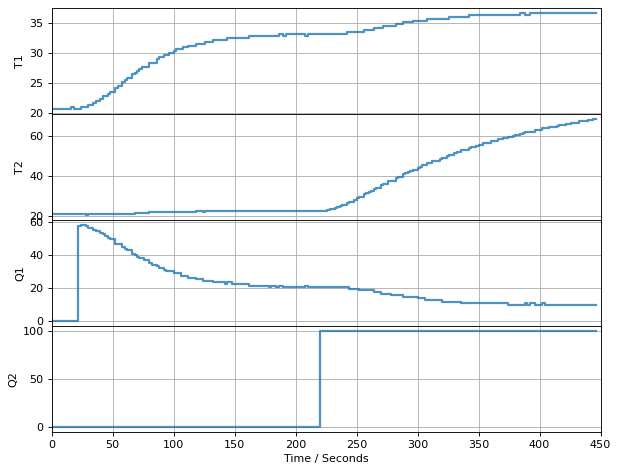

TCLab Model disconnected successfully.


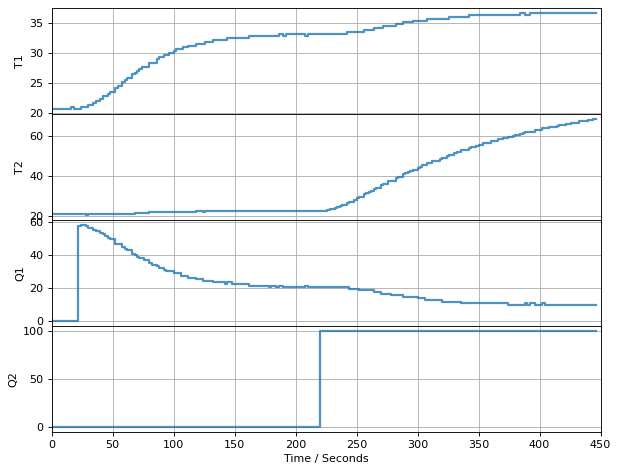

In [2]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

def setpoint(t):
    return 40 if t >= 20 else 0

def disturbance(t):
    return 100 if t>= 220 else 0

def experiment(controller, t_step=2, t_final=450,
               SP=lambda t: 40 if t >= 20 else 0, 
               DV=lambda t: 100 if t >= 220 else 0):

    TCLab = setup(connected=False, speedup=60)
    with TCLab() as lab:
        h = Historian(lab.sources)
        p = Plotter(h, t_final)

        # initialize manipulated variable
        lab.P1 = 200
        lab.P2 = 200
        lab.Q1(next(controller))

        # event loop
        for t in clock(t_final, t_step):
            T1 = lab.T1
            U1 = controller.send((SP(t), T1))
            lab.Q1(U1)
            lab.Q2(DV(t))
            p.update(t)    
            
controller = P(3.0)
experiment(controller, SP=setpoint, DV=disturbance)

For systems without significant time delay and with properly chosen parameters, proportional control can achieve a fast response to changes in setpoint. Note, however, the steady state may be different than the desired setpoint, sometimes unacceptably different. This steady-state error a short-coming of purely proportional control.

<hr>

**Study Question:** Did the proportional control acheive the setpoint? Did proportional control reject the disturbance? How serious is the problem?

<hr>

### Steady-State Offset

Proportional-only control provides no assurance the the process variable will eventually acquire the setpoint. To see this, consider the proportional control law

$$MV_k = \bar{MV} - K_P e_k$$

in the limit $k\rightarrow\infty$. 

$$e_{\infty} = \frac{\bar{MV} - MV_{\infty}}{K_P}$$

The error $e_\infty$ expresses the steady-state difference between a process variable and it setpoint. With proportional control, the only options to reduce steady-state offset are 

1. Increase $K_P$. This leads to increasing oscillations and relay-like behavior of the manipulated variable.
2. Find a perfect initial estimate for $\bar{MV}$. If we could do this, we wouldn't need feedback control.

A persistent steady-state offset is most significant shortcoming of proportional-only control.

<hr>

**Study Question:** Test the simulation for values of $K_p$ that are twice as large, and half as large as demonstrated above. What do you notice about the steady-state error between the desired setpoint and the measured process variable?

<hr>

## Proportional-Integral (PI) Control

### Position form

Given a process variable $PV$ and setpoint $SP$, proportional-integral control is defined by the relation

\begin{align}
MV(t) & = \bar{MV} - K_P\left(PV(t) - SP(t)\right) - K_I\int_{-\infty}^t (PV(t') - SP(t'))\,dt'
\end{align}

or 

\begin{align}
MV(t) & = \bar{MV} - K_P e(t) - K_I\int_{-\infty}^t e(t') \,dt'
\end{align}

where

$$e(t) = PV(t) - SP(t)$$

where **$K_P$ is the proportional gain** and **$K_I$ is the integral gain**. When implemented in discrete time with time steps of length $h$, the basic rule for proportional-integral control becomes

\begin{align}
MV_k & = \bar{MV} - K_P(PV_k - SP_k) - h K_I\sum_{j=0}^{j=k}(PV_j - SP_j)
\end{align}

or 

\begin{align}
MV_k & = \bar{MV} - K_P e_k - h K_I\sum_{j=0}^{j=k}e_j
\end{align}

where

\begin{align}
e_k & = PV_k - SP_k
\end{align}

This is the so-called **position form** of PI control. The position form specifies the value (or "position") of the manipulated variable stricly in terms of the current and past values of the **error** signal $e_k$. Note the sign convention: A positive error occurs when the process variable is greater than the setpoint. The position form of PI control is rarely used in practice.

### Velocity form

A more common implementation of PI control is done by computing how much the manipulated variable changes at each time step, and incrementing the manipulated variable by that amount. Consecutive values of $MV$ are given by 

\begin{align}
MV_{k-1} & = \bar{MV} - K_p e_{k-1} - h K_i \sum_{j=0}^{k-1} e_{j} \\
MV_{k} & = \bar{MV} - K_p e_{k} - h K_i \sum_{j=0}^{k} e_{j}
\end{align}

Taking differences gives a formula for updating the value of $MV$ in response to process measurements or changes in setpoint.

\begin{align}
MV_{k} & = MV_{k-1} - K_p(e_{k} - e_{k-1}) - h K_i e_{k}
\end{align}

with $MV_0 = \bar{MV}$. Let's see how this works.

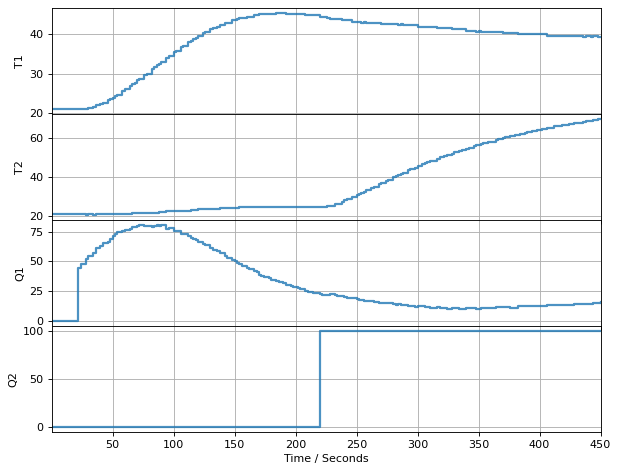

TCLab Model disconnected successfully.


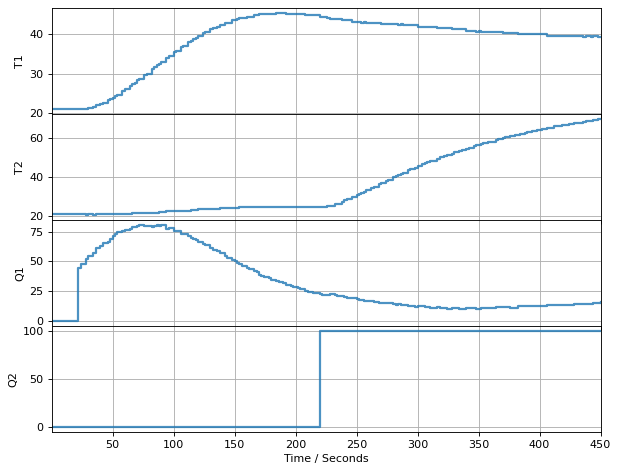

In [3]:
def PI(Kp, Ki, MV_bar=0, MV_min=0, MV_max=100):
    MV = MV_bar
    e_prev = 0
    while True:
        SP, PV = yield MV
        e = PV - SP
        MV += -Kp*(e - e_prev) - Ki*e
        e_prev = e
        
PI_controller = PI(3, 0.2)
experiment(PI_controller)

As we can see from this example, an important practical property of proportonal-integral control is **steady-state tracking of the setpoint.** In other words, for a steaady setpoint $\bar{SP}$, at steady-state 

\begin{align}
\lim_{k \rightarrow \infty} PV_k = \bar{SP}
\end{align}

To see why this is true, start with the velocity form of the proportional-integral controller

\begin{align}
MV_{k} & = MV_{k-1} - K_p(e_{k} - e_{k-1}) - h K_i e_{k}
\end{align}

At steady-state $MV_{k} = MV_{k-1}$ and $e_{k} = e_{k-1}$ leaving 

$$h K_i e_{k} = 0 \implies e_{k} = 0 \implies PV_{k} = \bar{SP}$$

Steady-state tracking is normally important in chemical process applications. For this reason, PI control is, by far, the most commonly encountered control used in the process industries.

## Empirical Tuning Rules

There are a number of **tuning rules** in the literature that provide recommended values for the proportional gain $K_P$. These rules require process information obtained from testing. For a first-order plus time-delay (FOPTD), the available process information includes gain $K$, process time constant $T$, and process time delay $\tau$.

Tuning rules are developed based on acheiving some performance criteria. Typical criteria include measures liks

\begin{align}
\text{IAE} & = \int_0^{\infty} |e(t)|dt \qquad \text{Integral Absolute Error}\\
\text{ISE} & = \int_0^{\infty} |e(t)|^2dt \qquad \text{Integral Square Error}\\
\text{ITAE} & = \int_0^{\infty} t|e(t)|dt \qquad \text{Integral Time Absolute Error}\\
\end{align}

Among the best known and commonly used tuning rules are listed in the following table (also see Astrom and Murray, Chapter 11):

| Type | $K_P$ | $K_I$ |
| :---: | :---: | :---: |
| P (Ziegler-Nichols) | $\frac{T}{K\tau}$ | |
| PI (Astrom and Murray) | $\frac{0.15\tau + 0.35T}{K\tau}$ | $\frac{0.46\tau + 0.02T}{K\tau^2}$ |
| PI (Aggressvie IMC) | $\frac{T}{K(\tau + \max(0.1T, 0.8\tau)}$ | $\frac{1}{K(\tau + \max(0.1T, 0.8\tau)}$ |
| PI (ITAE Tuning) | $\frac{0.586}{K}\left(\frac{\tau}{T}\right)^{-0.916}$  | $\frac{1.03  -  0 .165\left(\frac{\tau}{T}\right)}{T}K_P$ |
| PI (Morari and Zafiriou) | $\frac{T + 0.5\tau}{1.7 K \tau}$ | $\frac{1}{1.7K}$ |
| PI (Ziegler-Nichols) | $\frac{0.9 T}{K\tau}$ | $\frac{0.3T}{K\tau^2}$ |



<hr>

**Study Question:** Repeat the simulation experiments using the Ziegler-Nichols and the Astrom and Murray tuning rules for PI control. Compare the magnitude of the recommended control constants. Compare the resulting performance in response to regard to both setpoint tracking and disturbance rejection. Compare:

* Maximum overshoot
* Damping
* Time to acheive steady-state

<hr>